# Assignment 2 
Due date, November 18, 2022 - Max Grade - 10
## Exercise 1: (5/10): Clustering
In this exercise you have to pick velocities from a given semblance plot and use them for NMO correction of a CMP.\
Several parts of the assigment are given, just complete the missing parts.

In [2]:
#!pip install wiggle

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wiggle.wiggle import wiggle
from pathlib import Path
import os

Panel produced in Seismic Unix from a finite difference shot from the Marmousi model.\
The semblance panel is calculated as follows:
> suvelan nv=120 dv=50 fv=1500 < panel_proc.3012 > semb.3012b \
> sustrip < semb.3012b > sembbin.3012b 

The file "sembbin.3012b" is a binary file with dimensions 146 x 120.
The horizontal (velocity) and vertical (time) axes are specified below:

In [3]:
nv=120  # number of velocities
dv=50   # velocity interval 
fv=1500  # first velocity
dts=0.02 # time interval for semblance
nts=146  # number of time samples for semblance

Read the semblance in numpy, resample to nv, nts, and plot. 

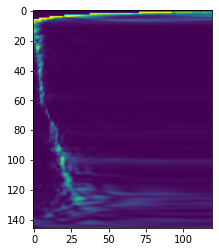

In [4]:
import numpy as np
semb = np.fromfile('sembbin.3012b', dtype='float32')
semb=semb.reshape((nv,nts))
semb=semb.T
plt.imshow(semb);

In [5]:
[nts,nvs] = semb.shape

We can define the axes (velaxis and timeaxis) as:

In [6]:
# Velocities for semblance
velaxis = np.arange(nvs)*dv+fv
timeaxis = np.arange(nts)*dts

Explanation: The semblance plot is a grid (x,y) with values Z that are the amplitudes of the semblance.\
We need to convert the panel (x,y,z) to pairs x,y so we can treat them as samples. 

We define 2 numpy arrays called tpair and xpair, containing the times and velocities for each high value on the semblance plot. 
* Scan every element on the semblance plot (loop in nvx and nts) 
* if the value of the plot is larger than a threshold, store the t,x values on the numpy arrays.
* You can define a corridor of minimum/maximum velocities that changes with time to help the picking.

In [25]:
x=[timeaxis.min(),timeaxis.max()]
y=[1500,3200]
tol=500
tpair = []
xpair = []
vthres= [np.interp(j*dts, x, y) for j in range(nts)]
vthres = np.array(vthres)
vthresplus = vthres+tol
vthresminus= vthres-tol
threshold=np.percentile(semb,95)
for i in range(nvs):
    vel_loc = velaxis[i]    
    for j in range(nts):        
        if semb[j,i] >= threshold and vel_loc < vthresplus[j] and vel_loc > vthresminus[j]:            
            tpair = np.append(tpair, timeaxis[j])
            xpair = np.append(xpair, velaxis[i])

Plot the picks (and the corridor if you used one)

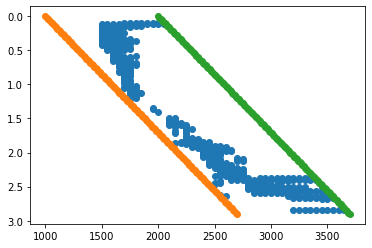

In [26]:
plt.scatter(xpair,tpair)
plt.scatter(vthresminus,timeaxis)
plt.scatter(vthresplus,timeaxis)
plt.gca().invert_yaxis()

### Apply clustering techniques to obtain velocities
This is the main part of the exercise. We want to pick the t,vel pairs we have from before.\
There are many points, but we want to obtain one per time, so the velocity as a function of time is **monovalued**.\
You can try *kmeans, dbscan, gaussian mixtures,* or any other techniques you like.\
TIP: do not forget to scale the data (and descale after) when needed. Is it always needed?

# Provided plotting functions from the practices.
Below there are several plotting functions for Gaussian mixtures, Kmeans and dbscan.
Use them if needed to plot the results.

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=20, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.gca().invert_yaxis()

In [ ]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    # gmm.score_samples: Compute the weighted log probabilities for each sample.
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.gca().invert_yaxis()

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    #plt.scatter(cores[:, 0], cores[:, 1],c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    #plt.scatter(anomalies[:, 0], anomalies[:, 1],c="r", marker=".", s=100)
    #plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.gca().invert_yaxis()
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

### Interpolate velocities to a regular time axis with the same dt as the data
The velocities we picked above are located at irregular intervals in time (approximately where reflectors occur).\
For using them in a NMO correction program, you need to interpolate them into a regular time axis.\
There are many ways to do this. For example, if you have the centers from kmeans, you could do this:
* read the centers from the clustering class
* apply inverse scaling if you use scaling
* sort them using numpy (interpolation usually requires monotically growing functions)
* putting the sorted values in pairs time, velocity
* use numpy.interp


In [ ]:
# sort before interpolation
km = kmeans.cluster_centers_
ks = scaler.inverse_transform(km)
kss=ks[np.argsort(ks[:,1]),:]
kms=km[np.argsort(km[:,1]),:]

In [ ]:
# Linear interpolation between points to obtain velocity trend
ks_x=kss[:,0]
ks_t=kss[:,1]
km_x=kms[:,0]
km_t=kms[:,1]
ks_x.sort()
ks_t.sort()
km_x.sort()
km_t.sort()
v_pair = np.reshape(ks_x,(len(ks_x),))
t_pair = np.reshape(ks_t,(len(ks_t),))

In [ ]:
nt=726
dt=0.004
cdptime=np.arange(nt)*dt
t_vnmo = np.reshape(cdptime,(len(cdptime),))
l_vnmo = np.interp(t_vnmo,t_pair,v_pair) 

### Apply NMO to the gather
The CMP gather is given in file cdp.3012b, the offset is in file offset

In [ ]:
import numpy as np
nt=726
nx=48
dt=0.004
cdp = np.fromfile('cdp.3012b', dtype='float32')
cdp=cdp.reshape((nx,nt))
cdp=cdp.T
cdptime=np.arange(nt)*dt

In [ ]:
offset= np.fromfile('offset.txt',dtype='int32')

In [ ]:
import numpy as np
import codecs

with codecs.open('offset.txt', encoding='utf-8-sig') as f:
    offset = np.loadtxt(f)

In [ ]:
offset[0:10]

In [ ]:
# Plot CDP
wiggle(cdp, cdptime, offset,sf= 0.08)
plt.xlabel("Trace number ", fontsize=13)
plt.ylabel("Time (s)", fontsize=13)
plt.title("Original CDP Gather")
plt.show()

Assuming you wrote your interpolated VRMS into cdptime and l_vnmo, you can use flat the gather using the NMO function below

In [ ]:
cdpc=np.zeros(shape=cdp.shape)

In [ ]:
# Loop in time: find pair t0 and vnmo from 1D profile
# Loop per offset, calculate the "corrected time" based on t0 and Vnmo, 
# access its correspondent indice in time and copy in the corrected gather these values
for i in range(nt):
    t0 = cdptime[i]
    vlnmo = l_vnmo[i]
    for j in range(len(offset)):
        tc = np.sqrt(t0**2 + offset[j]**2/vlnmo**2)
        #print(tc)
        tc_ind = round(tc/dt)
        #print(tc_ind)
        if tc_ind<nt:
            cdpc[i,j] = cdp[int(tc_ind),j]
        else:
            pass

### Plot the NMO corrected gather

## Exercise 2: (3/10): PCA
Using PCA for denoising: \
Take the same CMP from the previous exercise and apply PCA compression, for example using a similar flow as in the lecture.\
A common way of plotting data is to clip based on a percentile (for example 98% of maximum). Can you figure how to do that using numpy?\
HINT: use np.percentile

### Before NMO.
Apply PCA thresholding to the whole gather.

### After NMO. 
Does it work better?

### Random noise
Add random noise to the gather. Does it remove efficiently?

### BONUS: +0.5/10 Small windows
Divide the gather in small windows and do the same. Does it work better?

## Exercise 3 (2/10): Linear Regression
Use sklearn linear regression (perhaps with polynomial features) to interpolate the CDP gather below.\
For simplicity, use the original traces as the target (y). \
As an extension (not needed for the assignment) try to use the interpolator to the new cdp 3000.

In [ ]:
import numpy as np
cdpgap=np.copy(cdp)
cdpgap[:,20:25]=0;

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(cdpgap,aspect='auto',clim=[-1000,1000])

In [ ]:
nt=726
nx=48
dt=0.004
cdpnew = np.fromfile('cdp.3000b', dtype='float32')
cdpnew=cdpnew.reshape((nx,nt))
cdpnew=cdpnew.T

In [ ]:
cdpnewgap=np.copy(cdpnew)
cdpnewgap[:,20:25]=0;

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(cdpgap,aspect='auto',clim=[-1000,1000])